<a href="https://colab.research.google.com/github/hyo2/5emotion_KoBert/blob/master/5emotion_KoBert__shuffle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==4.8.1
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.7 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 24.9 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595735 sha256=6fbd9b91b6126bd16ba5eaa259c1730334943ce7822d0baa0167e37983f7753e
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 32.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.p

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-07qerq80
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-07qerq80
     |████████████████████████████████| 132 kB 9.7 MB/s 
     |████████████████████████████████| 4.5 MB 45.9 MB/s 
     |████████████████████████████████| 79 kB 5.6 MB/s 
     |████████████████████████████████| 9.0 MB 52.1 MB/s 
     |████████████████████████████████| 127 kB 52.5 MB/s 
  Created wheel for kobert: filename=kobert-0.2.3-py3-none-any.whl size=15674 sha256=255eb325efd34f7bbbf83cc3743b032a5b8d3e312722e9e88ada5aae5ca9ad3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6sodv7_x/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urll

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EarlyStopping class

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    # 주어진 patience 후에도 test_loss 개선 X -> 조기 종료
    def __init__(self, patience=5, verbose=False, delta=0):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.test_loss_min = np.Inf
        self.delta = delta

    def __call__(self, test_loss, model):

        score = -test_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(test_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(test_loss, model)
            self.counter = 0

    def save_checkpoint(self, test_loss, model):
        '''Saves model when test loss decrease.'''
        if self.verbose:
            print(f'Test loss decreased ({self.test_loss_min:.6f} --> {test_loss:.6f}).  Saving model ...')

        # 모델 저장
        path='/content/drive/MyDrive/new_mood/model4/'
        torch.save(model, path + '5emotion_Kobert_model4.pt') # 전체 모델 저장

        torch.save(model.state_dict(),path + '5emotion_Kobert_model4_state_dict.pt') # 모델 객체의 state_dict 저장

        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, path + '5emotion_Kobert_model4_all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

        self.test_loss_min = test_loss

# 설정값들 (파라미터 포함)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

## GPU
device = torch.device("cuda:0")

# BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

import pandas as pd
emotion_data = pd.read_csv('/content/drive/MyDrive/new_mood/5emotions_shuffle.csv')

emotion_data.loc[(emotion_data['Emotion'] == "분노"), 'Emotion'] = 0  #분노 => 0
emotion_data.loc[(emotion_data['Emotion'] == "슬픔"), 'Emotion'] = 1  #슬픔 => 1
emotion_data.loc[(emotion_data['Emotion'] == "놀람"), 'Emotion'] = 2  #놀람 => 2
emotion_data.loc[(emotion_data['Emotion'] == "중립"), 'Emotion'] = 3  #중립 => 3
emotion_data.loc[(emotion_data['Emotion'] == "행복"), 'Emotion'] = 4 #행복 => 4

data_list=[]
for q, label in zip(emotion_data['Sentence'], emotion_data['Emotion']):
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

# 학습, 테스트 데이터 분리
from sklearn.model_selection import train_test_split
# train:test=8:2
# random_state = 0 => 랜덤하게 추출
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=0)

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

# torch 형식의 dataset 만들기
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5, # class 5개로 분류(5가지 감정)
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

# BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

# Prepare optimizer and schedule (linear warmup and decay) (optimizer와 schedule 설정)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 범주형 교차 엔트로피(pytorch용 손실함수)-다중분류

# early_stopping 설정
patience = 2
early_stopping = EarlyStopping(patience, verbose=True)

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Training

In [ ]:
training_stats = []

# 학습시키기
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    test_loss = 0.0

    # 그래프 그릴 때 쓸 변수
    train_acc_log = 0.0
    train_loss_log = 0.0
    test_acc_log = 0.0
    test_loss_log = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward() # 모델의 파라미터와 관련된 loss의 그래디언트 계산
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        train_loss += loss.item()# *batch_size # total loss 누적
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} train loss {:.3f} train acc {:.3f}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    avg_train_loss = train_loss/len(train_dataloader) # 평균적인 총 손실
    print("epoch {} train loss {:.3f} train acc {:.3f}".format(e+1, avg_train_loss, train_acc / (batch_id+1)))
    train_acc_log = train_acc / (batch_id+1)
    train_loss_log = avg_train_loss
    # print("train_acc_log {} train_loss_log {}".format(train_acc_log, train_loss_log))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        test_acc += calc_accuracy(out, label)
        test_loss += loss.item()# *batch_size # total loss 누적
    avg_test_loss = test_loss/len(test_dataloader)
    print("epoch {} test loss {:.3f} test acc {:.3f}".format(e+1, avg_test_loss, test_acc / (batch_id+1)))
    test_acc_log = test_acc / (batch_id+1)
    test_loss_log = avg_test_loss
    # print("test_acc_log {} test_loss_log {}".format(test_acc_log, test_loss_log))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': e+1,
            'train_acc': train_acc_log,
            'train_loss': train_loss_log,
            'test_acc': test_acc_log,
            'test_loss': test_loss_log,

        }
    )

    early_stopping(avg_test_loss, model)
	  # early stopping
    if early_stopping.early_stop:
      print("Early stopping")
      break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/841 [00:00<?, ?it/s]

epoch 1 batch id 1 train loss 1.609 train acc 0.297
epoch 1 batch id 201 train loss 1.260 train acc 0.334
epoch 1 batch id 401 train loss 0.847 train acc 0.484
epoch 1 batch id 601 train loss 0.770 train acc 0.558
epoch 1 batch id 801 train loss 0.873 train acc 0.599
epoch 1 train loss 1.008 train acc 0.605


  0%|          | 0/211 [00:00<?, ?it/s]

epoch 1 test loss 0.757 test acc 0.724
Test loss decreased (inf --> 0.756620).  Saving model ...


  0%|          | 0/841 [00:00<?, ?it/s]

epoch 2 batch id 1 train loss 0.783 train acc 0.719
epoch 2 batch id 201 train loss 0.985 train acc 0.738
epoch 2 batch id 401 train loss 0.566 train acc 0.740
epoch 2 batch id 601 train loss 0.571 train acc 0.748
epoch 2 batch id 801 train loss 0.620 train acc 0.758
epoch 2 train loss 0.651 train acc 0.760


  0%|          | 0/211 [00:00<?, ?it/s]

epoch 2 test loss 0.670 test acc 0.758
Test loss decreased (0.756620 --> 0.670283).  Saving model ...


  0%|          | 0/841 [00:00<?, ?it/s]

epoch 3 batch id 1 train loss 0.785 train acc 0.734
epoch 3 batch id 201 train loss 0.845 train acc 0.803
epoch 3 batch id 401 train loss 0.418 train acc 0.808
epoch 3 batch id 601 train loss 0.420 train acc 0.814
epoch 3 batch id 801 train loss 0.661 train acc 0.822
epoch 3 train loss 0.494 train acc 0.823


  0%|          | 0/211 [00:00<?, ?it/s]

epoch 3 test loss 0.703 test acc 0.760
EarlyStopping counter: 1 out of 2


  0%|          | 0/841 [00:00<?, ?it/s]

epoch 4 batch id 1 train loss 0.569 train acc 0.812
epoch 4 batch id 201 train loss 0.616 train acc 0.862
epoch 4 batch id 401 train loss 0.250 train acc 0.862
epoch 4 batch id 601 train loss 0.392 train acc 0.867
epoch 4 batch id 801 train loss 0.553 train acc 0.873
epoch 4 train loss 0.359 train acc 0.874


  0%|          | 0/211 [00:00<?, ?it/s]

epoch 4 test loss 0.816 test acc 0.751
EarlyStopping counter: 2 out of 2
Early stopping


# 시각화

In [ ]:
# epoch=10, batch_size=64, lr=5e-5

import pandas as pd
# Display floats with two decimal places.
pd.set_option('precision', 3)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,train_acc,train_loss,test_acc,test_loss
epoch,,,,
1,0.605,1.008,0.724,0.757
2,0.760,0.651,0.758,0.670
3,0.823,0.494,0.760,0.703
4,0.874,0.359,0.751,0.816


- 그래프

In [ ]:
def plot_training_stats(df_stats, num_epochs=5):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.2)
    plt.rcParams["figure.figsize"] = (15,6)

    xticks = list(range(1, num_epochs+1))

    plt.subplot(221)

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(df_stats['train_loss'], 'b-o', label="Training")
    ax1.plot(df_stats['test_loss'], 'g-o', label="Test")
    ax1.set_xticks(xticks)
    ax1.set_title("Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(df_stats['train_acc'], 'b-o', label="Training")
    ax2.plot(df_stats['test_acc'], 'g-o', label="Test")
    ax2.set_xticks(xticks)
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()

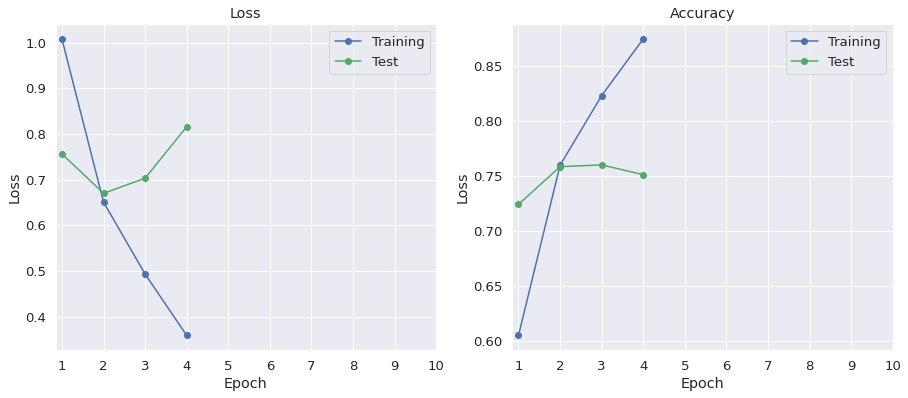

In [ ]:
# epoch=10, batch_size=64, lr=5e-5
% matplotlib inline
plot_training_stats(df_stats, num_epochs)

# 불러오기

In [ ]:
import os
os.chdir('/content/drive/MyDrive/new_mood/model4/')

model = torch.load('5emotion_Kobert_model4.pt') # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load('5emotion_Kobert_model4_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load('5emotion_Kobert_model4_all.tar') # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

In [ ]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    # with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            print(logits)

            if np.argmax(logits) == 0:
                test_eval.append("분노")
            elif np.argmax(logits) == 1:
                test_eval.append("슬픔")
            elif np.argmax(logits) == 2:
                test_eval.append("놀람")
            elif np.argmax(logits) == 3:
                test_eval.append("중립")
            elif np.argmax(logits) == 4:
                test_eval.append("기쁨")

        print("결과: "+ test_eval[0])

In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git
!pip install soynlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-3wjpqcoe
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-3wjpqcoe
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=137267c2b52f92f245963d7f025e0edd2c74a7bbe7e61f9dedf2819e2ac55ece
  Stored in directory: /tmp/pip-ephem-wheel-cache-jzepxeg3/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 416 kB 30.9 MB/s 


In [ ]:
import re
from hanspell import spell_checker
from soynlp.normalizer import *

def cleaning(line):
    parseText = re.compile('[^ \u3131-\u3163\uac00-\ud7a3]+').sub('', line)

    spelled_sent = spell_checker.check(parseText)
    checkedText = spelled_sent.checked # 맞춤법 교정 후 문장 저장(띄어쓰기까지 교정함)

    refinedText = repeat_normalize(checkedText, num_repeats=2) # 반복 문자 정제(ex) ㅋㅋㅋㅋㅋ, ㅎㅎㅎ)
    return refinedText

In [ ]:
def predict2(predict_sentence):
    predict_sentence = cleaning(predict_sentence)
    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    # with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            preds = np.array(logits)
            print(preds)
            pred_class = np.argmax(preds) # preds 배열의 최댓값 인덱스
            print(pred_class)

            if pred_class == 0:
                test_eval.append("분노")
            elif pred_class == 1:
                test_eval.append("슬픔")
            elif pred_class == 2:
                test_eval.append("놀람")
            elif pred_class == 3:
                test_eval.append("중립")
            elif pred_class == 4:
                test_eval.append("기쁨")

        print("결과: "+ test_eval[0])

In [ ]:
sentence = input("input: ")
predict(sentence)
print('\n')

input: 아들이 군대에 갔다


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[ 0.59705     1.6371678  -0.13831016 -3.4775047   1.5047603 ]
결과: 슬픔


